Finding the Efficient Frontier using Monte
Carlo simulations

1. Import the libraries:

In [2]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd


     |████████████████████████████████| 6.4 MB 11.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


2. Set up the parameters:

In [3]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [4]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)

[*********************100%***********************]  4 of 4 completed


4. Calculate annualized average returns and the corresponding standard deviation:

In [5]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

5. Simulate random portfolio weights:

In [6]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate the portfolio metrics:

In [11]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a DataFrame containing all the data:

In [12]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,'volatility': portf_vol,'sharpe_ratio':portf_sharpe_ratio})

8. Locate the points creating the Efficient Frontier:

In [13]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(),portf_results_df.returns.max(),N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
  if portf_rtns_ef[point_index] not in portf_rtns:
    indices_to_skip.append(point_index)
    continue
  matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
  portf_vol_ef.append(np.min(portf_vol[matched_ind]))
  
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

9. Plot the Efficient Frontier:

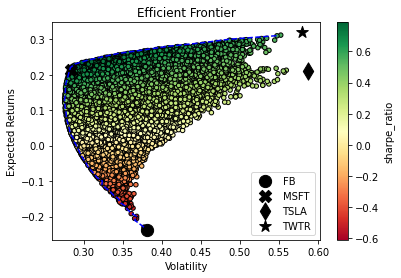

In [23]:
import matplotlib.pyplot as plt

MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',y='returns', c='sharpe_ratio',cmap='RdYlGn', edgecolors='black',ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')

for asset_index in range(n_assets):
  ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),y=avg_returns[asset_index],marker=MARKS[asset_index],s=150,color='black',label=RISKY_ASSETS[asset_index])
ax.legend()

In [24]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [25]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
  print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS,
weights[np.argmax(portf_results_df.sharpe_ratio)]):
  print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 23.42% volatility: 29.77% sharpe_ratio: 78.68% 
Weights
FB: 0.01% MSFT: 75.18% TSLA: 5.80% TWTR: 19.00% 

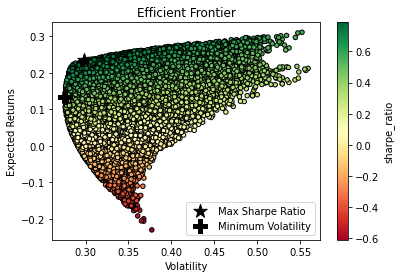

In [26]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',y='returns', c='sharpe_ratio',cmap='RdYlGn', edgecolors='black',ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,y=max_sharpe_portf.returns,c='black', marker='*',s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,y=min_vol_portf.returns,c='black', marker='P',s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',title='Efficient Frontier')
ax.legend()